In [1]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaled_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_indices = np.where(label == 0)
anomalous_indices = np.where(label == 1)


cuda
NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [2]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [3]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Linear(16, 8), 
            nn.ReLU(),
            nn.Linear(8, 4), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))



# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model


def print_eval(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("F1 = {}".format(f1_score(labels, predictions)))
  print(confusion_matrix(labels, predictions))

# Plot reconstruction error histogram
def plot_reconstruction_error(model, features, percentile=95):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    errors = []
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            errors.extend(batch_errors.cpu().numpy())

    threshold = np.percentile(errors, percentile)
    anomalies = np.sum(np.array(errors) > threshold)

    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({percentile}%)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Histogram')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Anomaly threshold: {threshold:.6f}")
    print(f"Detected anomalies: {anomalies}")


# Cross Validation without Scalers

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (872, 14, 4096)
Fold 1
Epoch 1/15, Loss: 0.847341
Epoch 2/15, Loss: 0.664645
Epoch 3/15, Loss: 0.664293
Epoch 4/15, Loss: 0.664155
Epoch 5/15, Loss: 0.664047
Epoch 6/15, Loss: 0.663941
Epoch 7/15, Loss: 0.663861
Epoch 8/15, Loss: 0.663819
Epoch 9/15, Loss: 0.663758
Epoch 10/15, Loss: 0.663677
Epoch 11/15, Loss: 0.663518
Epoch 12/15, Loss: 0.661871
Epoch 13/15, Loss: 0.659791
Epoch 14/15, Loss: 0.659374
Epoch 15/15, Loss: 0.658535


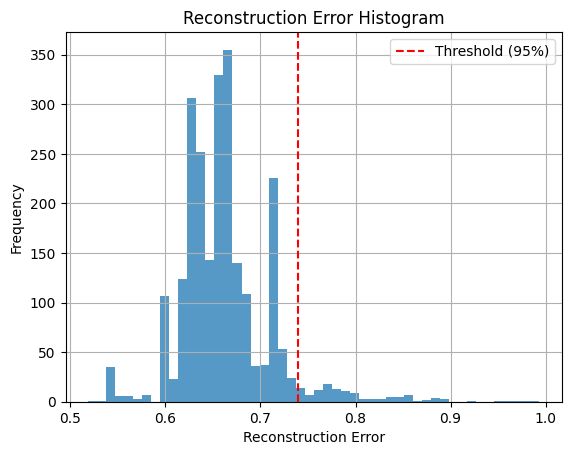

Anomaly threshold: 0.739729
Detected anomalies: 123
Accuracy = 0.8228571428571428
Precision = 0.6666666666666666
Recall = 0.32432432432432434
F1 = 0.4363636363636364
[[132   6]
 [ 25  12]]
Fold 2
Epoch 1/15, Loss: 0.898076
Epoch 2/15, Loss: 0.664296
Epoch 3/15, Loss: 0.663841
Epoch 4/15, Loss: 0.663746
Epoch 5/15, Loss: 0.663693
Epoch 6/15, Loss: 0.663686
Epoch 7/15, Loss: 0.663682
Epoch 8/15, Loss: 0.663688
Epoch 9/15, Loss: 0.663689
Epoch 10/15, Loss: 0.663662
Epoch 11/15, Loss: 0.663668
Epoch 12/15, Loss: 0.663667
Epoch 13/15, Loss: 0.663660
Epoch 14/15, Loss: 0.663673
Epoch 15/15, Loss: 0.663662


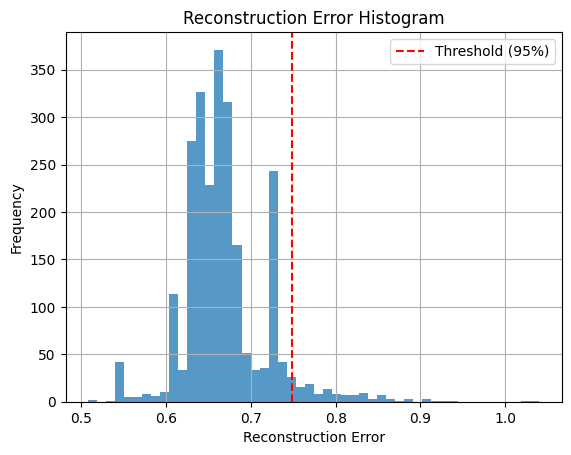

Anomaly threshold: 0.748126
Detected anomalies: 123
Accuracy = 0.8342857142857143
Precision = 0.7222222222222222
Recall = 0.35135135135135137
F1 = 0.4727272727272727
[[133   5]
 [ 24  13]]
Fold 3
Epoch 1/15, Loss: 0.919261
Epoch 2/15, Loss: 0.663961
Epoch 3/15, Loss: 0.663676
Epoch 4/15, Loss: 0.663676
Epoch 5/15, Loss: 0.663663
Epoch 6/15, Loss: 0.663665
Epoch 7/15, Loss: 0.663659
Epoch 8/15, Loss: 0.663653
Epoch 9/15, Loss: 0.663659
Epoch 10/15, Loss: 0.663664
Epoch 11/15, Loss: 0.663648
Epoch 12/15, Loss: 0.663664
Epoch 13/15, Loss: 0.663654
Epoch 14/15, Loss: 0.663650
Epoch 15/15, Loss: 0.663651


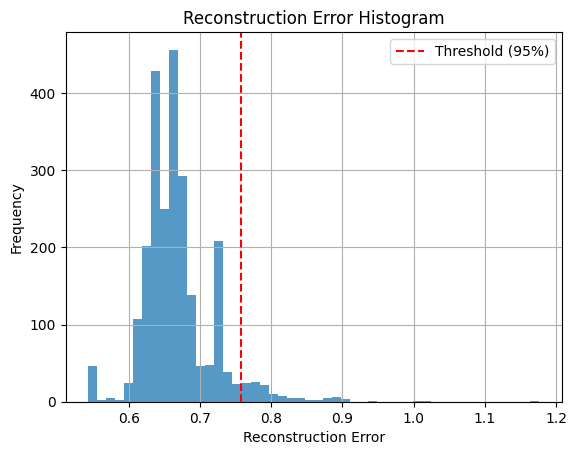

Anomaly threshold: 0.757096
Detected anomalies: 122
Accuracy = 0.8390804597701149
Precision = 0.7222222222222222
Recall = 0.3611111111111111
F1 = 0.4814814814814815
[[133   5]
 [ 23  13]]
Fold 4
Epoch 1/15, Loss: 0.887229
Epoch 2/15, Loss: 0.665511
Epoch 3/15, Loss: 0.665276
Epoch 4/15, Loss: 0.665062
Epoch 5/15, Loss: 0.664830
Epoch 6/15, Loss: 0.664685
Epoch 7/15, Loss: 0.664474
Epoch 8/15, Loss: 0.664291
Epoch 9/15, Loss: 0.664059
Epoch 10/15, Loss: 0.663928
Epoch 11/15, Loss: 0.663760
Epoch 12/15, Loss: 0.662964
Epoch 13/15, Loss: 0.660475
Epoch 14/15, Loss: 0.659998
Epoch 15/15, Loss: 0.659901


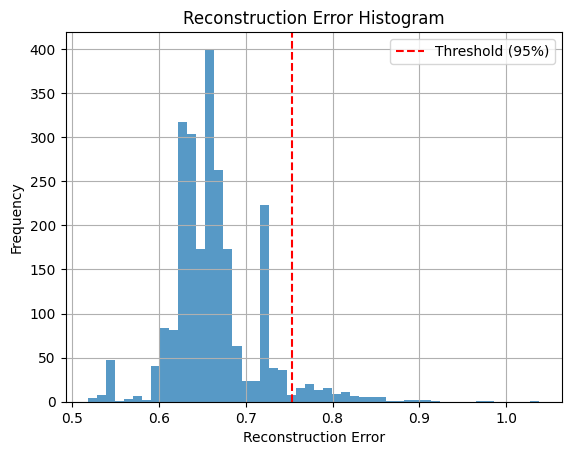

Anomaly threshold: 0.753377
Detected anomalies: 122
Accuracy = 0.8160919540229885
Precision = 0.6111111111111112
Recall = 0.3055555555555556
F1 = 0.40740740740740744
[[131   7]
 [ 25  11]]
Fold 5
Epoch 1/15, Loss: 0.867259
Epoch 2/15, Loss: 0.666430
Epoch 3/15, Loss: 0.666058
Epoch 4/15, Loss: 0.665875
Epoch 5/15, Loss: 0.665617
Epoch 6/15, Loss: 0.665425
Epoch 7/15, Loss: 0.665214
Epoch 8/15, Loss: 0.664997
Epoch 9/15, Loss: 0.664679
Epoch 10/15, Loss: 0.664370
Epoch 11/15, Loss: 0.664145
Epoch 12/15, Loss: 0.663886
Epoch 13/15, Loss: 0.663314
Epoch 14/15, Loss: 0.661331
Epoch 15/15, Loss: 0.660235


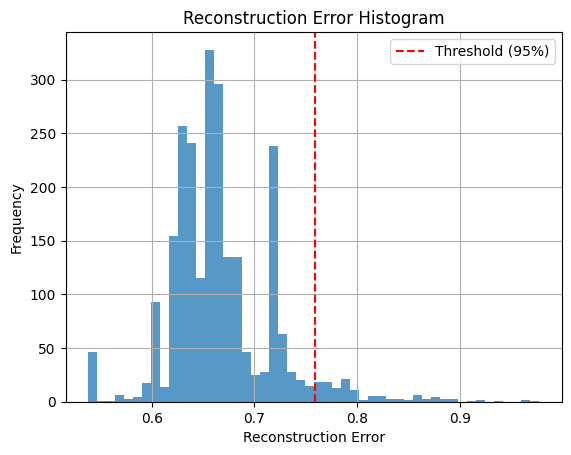

Anomaly threshold: 0.759117
Detected anomalies: 122
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.5
F1 = 0.6666666666666666
[[138   0]
 [ 18  18]]


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
features = process_dataset(data)
print("Features shape:", features.shape)

for fold, (train_idx, val_idx) in enumerate(skf.split(features, label)):
    print(f"Fold {fold + 1}")
    train_fold_data, val_fold_data = features[train_idx], features[val_idx]
    train_fold_labels, val_fold_labels = label[train_idx], label[val_idx]

    # Train autoencoder on the training fold
    model = train_autoencoder(features[normal_indices], epochs=15, batch_size=64)

    # Evaluate on validation fold
    x_val = torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader_val = DataLoader(TensorDataset(x_val), batch_size=64)
    
    # Compute reconstruction errors
    x = model(torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)).cpu().detach().numpy()
    errors = np.mean((x - val_fold_data.reshape(-1, 4096)) ** 2, axis=1)

    # Reshape to (175, 14)
    errors = errors.reshape(val_fold_data.shape[0], val_fold_data.shape[1])

    # Aggregate per sample (e.g., mean across channels)
    sample_errors = np.mean(errors, axis=1)

    percentile = 90
    # Thresholding
    threshold = np.percentile(sample_errors, percentile)
    predictions = (sample_errors > threshold).astype(int)


    
    plot_reconstruction_error(model, val_fold_data, percentile=95)
    print_eval(predictions, val_fold_labels)

# Cross Validation with StandardScaler

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (872, 14, 4096)
Fold 1
Epoch 1/15, Loss: 0.872067
Epoch 2/15, Loss: 0.676945
Epoch 3/15, Loss: 0.676621
Epoch 4/15, Loss: 0.676420
Epoch 5/15, Loss: 0.676191
Epoch 6/15, Loss: 0.675976
Epoch 7/15, Loss: 0.675774
Epoch 8/15, Loss: 0.675587
Epoch 9/15, Loss: 0.675392
Epoch 10/15, Loss: 0.675249
Epoch 11/15, Loss: 0.675150
Epoch 12/15, Loss: 0.675092
Epoch 13/15, Loss: 0.674995
Epoch 14/15, Loss: 0.674746
Epoch 15/15, Loss: 0.673441


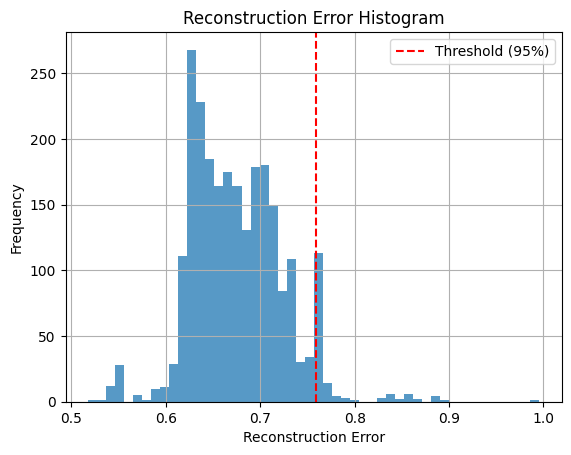

Anomaly threshold: 0.759074
Detected anomalies: 123
Accuracy = 0.8228571428571428
Precision = 0.6666666666666666
Recall = 0.32432432432432434
F1 = 0.4363636363636364
[[132   6]
 [ 25  12]]
Fold 2
Epoch 1/15, Loss: 0.917000
Epoch 2/15, Loss: 0.675399
Epoch 3/15, Loss: 0.675011
Epoch 4/15, Loss: 0.674965
Epoch 5/15, Loss: 0.673587
Epoch 6/15, Loss: 0.671264
Epoch 7/15, Loss: 0.670655
Epoch 8/15, Loss: 0.670375
Epoch 9/15, Loss: 0.669779
Epoch 10/15, Loss: 0.669425
Epoch 11/15, Loss: 0.669264
Epoch 12/15, Loss: 0.669153
Epoch 13/15, Loss: 0.669064
Epoch 14/15, Loss: 0.668980
Epoch 15/15, Loss: 0.668900


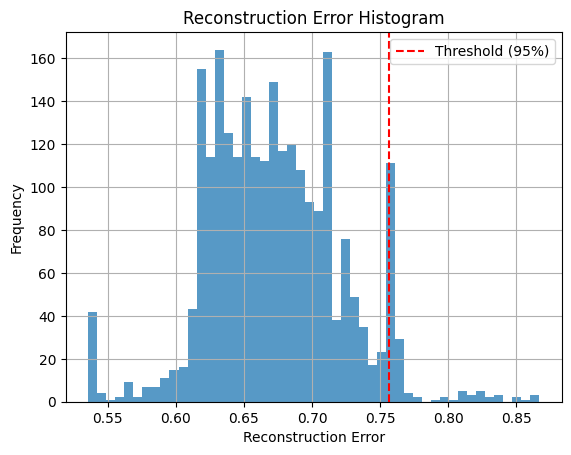

Anomaly threshold: 0.756416
Detected anomalies: 123
Accuracy = 0.8571428571428571
Precision = 0.8333333333333334
Recall = 0.40540540540540543
F1 = 0.5454545454545455
[[135   3]
 [ 22  15]]
Fold 3
Epoch 1/15, Loss: 0.831438
Epoch 2/15, Loss: 0.676384
Epoch 3/15, Loss: 0.675727
Epoch 4/15, Loss: 0.673383
Epoch 5/15, Loss: 0.672044
Epoch 6/15, Loss: 0.671705
Epoch 7/15, Loss: 0.671454
Epoch 8/15, Loss: 0.671248
Epoch 9/15, Loss: 0.671072
Epoch 10/15, Loss: 0.670941
Epoch 11/15, Loss: 0.670838
Epoch 12/15, Loss: 0.670743
Epoch 13/15, Loss: 0.670616
Epoch 14/15, Loss: 0.670504
Epoch 15/15, Loss: 0.670390


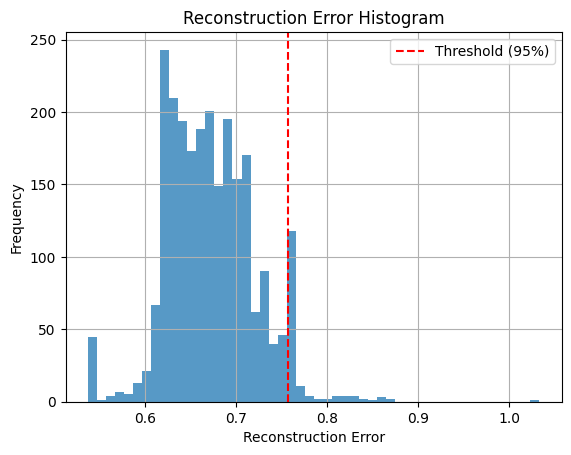

Anomaly threshold: 0.756993
Detected anomalies: 122
Accuracy = 0.8275862068965517
Precision = 0.6666666666666666
Recall = 0.3333333333333333
F1 = 0.4444444444444444
[[132   6]
 [ 24  12]]
Fold 4
Epoch 1/15, Loss: 0.827755
Epoch 2/15, Loss: 0.676676
Epoch 3/15, Loss: 0.676370
Epoch 4/15, Loss: 0.676145
Epoch 5/15, Loss: 0.676007
Epoch 6/15, Loss: 0.675865
Epoch 7/15, Loss: 0.675671
Epoch 8/15, Loss: 0.675564
Epoch 9/15, Loss: 0.675407
Epoch 10/15, Loss: 0.675305
Epoch 11/15, Loss: 0.675186
Epoch 12/15, Loss: 0.675131
Epoch 13/15, Loss: 0.675052
Epoch 14/15, Loss: 0.674992
Epoch 15/15, Loss: 0.674898


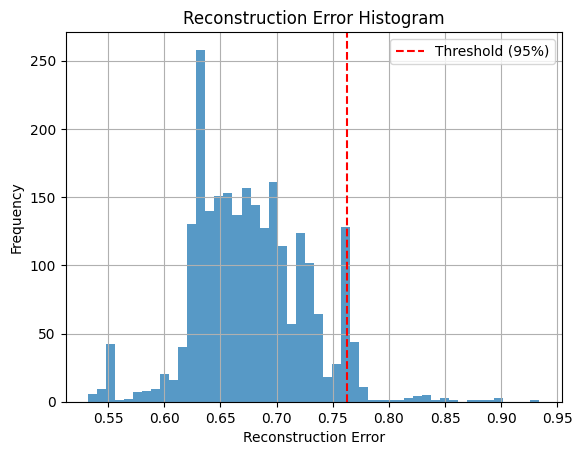

Anomaly threshold: 0.762625
Detected anomalies: 122
Accuracy = 0.8160919540229885
Precision = 0.6111111111111112
Recall = 0.3055555555555556
F1 = 0.40740740740740744
[[131   7]
 [ 25  11]]
Fold 5
Epoch 1/15, Loss: 0.894817
Epoch 2/15, Loss: 0.676015
Epoch 3/15, Loss: 0.675554
Epoch 4/15, Loss: 0.675291
Epoch 5/15, Loss: 0.675113
Epoch 6/15, Loss: 0.675035
Epoch 7/15, Loss: 0.674980
Epoch 8/15, Loss: 0.674942
Epoch 9/15, Loss: 0.674760
Epoch 10/15, Loss: 0.673119
Epoch 11/15, Loss: 0.672173
Epoch 12/15, Loss: 0.672096
Epoch 13/15, Loss: 0.672034
Epoch 14/15, Loss: 0.671958
Epoch 15/15, Loss: 0.671778


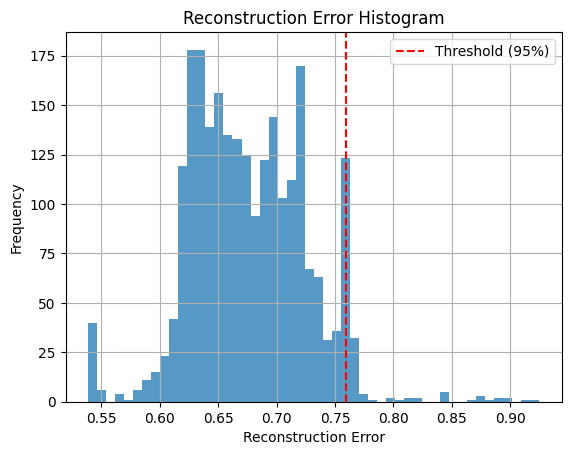

Anomaly threshold: 0.759237
Detected anomalies: 122
Accuracy = 0.896551724137931
Precision = 1.0
Recall = 0.5
F1 = 0.6666666666666666
[[138   0]
 [ 18  18]]


In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)
for fold, (train_idx, val_idx) in enumerate(skf.split(features, label)):
    print(f"Fold {fold + 1}")
    train_fold_data, val_fold_data = features[train_idx], features[val_idx]
    train_fold_labels, val_fold_labels = label[train_idx], label[val_idx]

    # Train autoencoder on the training fold
    model = train_autoencoder(features[normal_indices], epochs=15, batch_size=64)

    # Evaluate on validation fold
    x_val = torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader_val = DataLoader(TensorDataset(x_val), batch_size=64)
    
    # Compute reconstruction errors
    x = model(torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)).cpu().detach().numpy()
    errors = np.mean((x - val_fold_data.reshape(-1, 4096)) ** 2, axis=1)

    # Reshape to (175, 14)
    errors = errors.reshape(val_fold_data.shape[0], val_fold_data.shape[1])

    # Aggregate per sample (e.g., mean across channels)
    sample_errors = np.mean(errors, axis=1)

    percentile = 90
    # Thresholding
    threshold = np.percentile(sample_errors, percentile)
    predictions = (sample_errors > threshold).astype(int)


    
    plot_reconstruction_error(model, val_fold_data, percentile=95)
    print_eval(predictions, val_fold_labels)

# Cross Validation with MinMax

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (872, 14, 4096)
Fold 1
Epoch 1/15, Loss: 0.852780
Epoch 2/15, Loss: 0.715806
Epoch 3/15, Loss: 0.715587
Epoch 4/15, Loss: 0.715483
Epoch 5/15, Loss: 0.715349
Epoch 6/15, Loss: 0.715148
Epoch 7/15, Loss: 0.714989
Epoch 8/15, Loss: 0.714770
Epoch 9/15, Loss: 0.714565
Epoch 10/15, Loss: 0.714436
Epoch 11/15, Loss: 0.714340
Epoch 12/15, Loss: 0.714253
Epoch 13/15, Loss: 0.714146
Epoch 14/15, Loss: 0.714073
Epoch 15/15, Loss: 0.714025


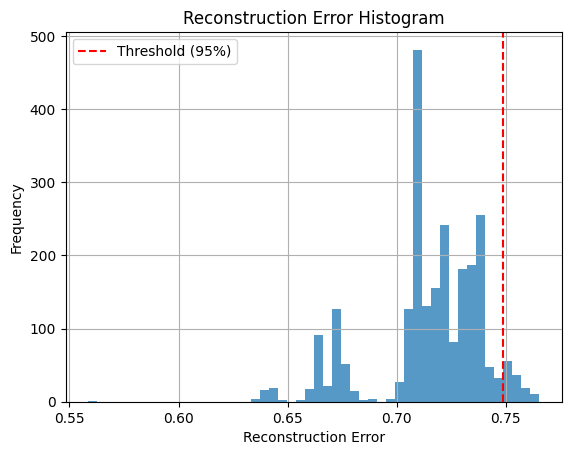

Anomaly threshold: 0.748621
Detected anomalies: 123
Accuracy = 0.7542857142857143
Precision = 0.3333333333333333
Recall = 0.16216216216216217
F1 = 0.2181818181818182
[[126  12]
 [ 31   6]]
Fold 2
Epoch 1/15, Loss: 0.888891
Epoch 2/15, Loss: 0.715248
Epoch 3/15, Loss: 0.715012
Epoch 4/15, Loss: 0.714819
Epoch 5/15, Loss: 0.714661
Epoch 6/15, Loss: 0.714583
Epoch 7/15, Loss: 0.714507
Epoch 8/15, Loss: 0.714435
Epoch 9/15, Loss: 0.714356
Epoch 10/15, Loss: 0.714248
Epoch 11/15, Loss: 0.714140
Epoch 12/15, Loss: 0.714050
Epoch 13/15, Loss: 0.713989
Epoch 14/15, Loss: 0.713945
Epoch 15/15, Loss: 0.713876


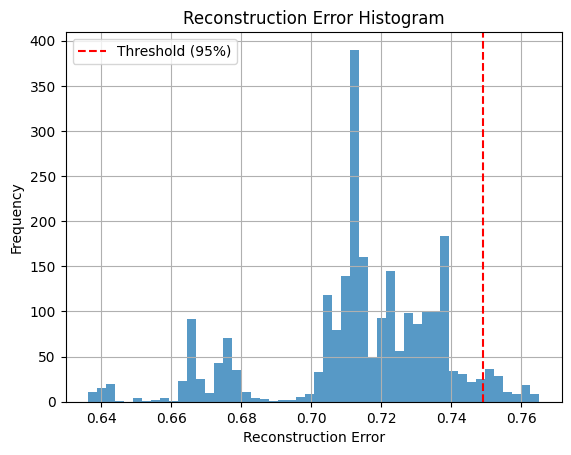

Anomaly threshold: 0.748930
Detected anomalies: 123
Accuracy = 0.7885714285714286
Precision = 0.5
Recall = 0.24324324324324326
F1 = 0.3272727272727273
[[129   9]
 [ 28   9]]
Fold 3
Epoch 1/15, Loss: 0.857907
Epoch 2/15, Loss: 0.715484
Epoch 3/15, Loss: 0.715333
Epoch 4/15, Loss: 0.715213
Epoch 5/15, Loss: 0.715130
Epoch 6/15, Loss: 0.715016
Epoch 7/15, Loss: 0.714935
Epoch 8/15, Loss: 0.714819
Epoch 9/15, Loss: 0.714704
Epoch 10/15, Loss: 0.714576
Epoch 11/15, Loss: 0.714459
Epoch 12/15, Loss: 0.714310
Epoch 13/15, Loss: 0.714163
Epoch 14/15, Loss: 0.714070
Epoch 15/15, Loss: 0.713979


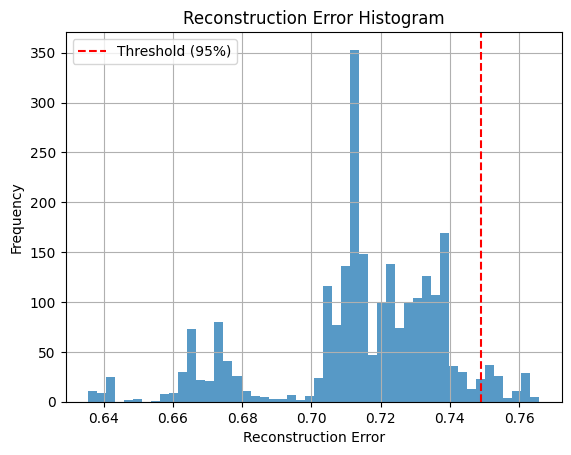

Anomaly threshold: 0.749125
Detected anomalies: 122
Accuracy = 0.7471264367816092
Precision = 0.2777777777777778
Recall = 0.1388888888888889
F1 = 0.1851851851851852
[[125  13]
 [ 31   5]]
Fold 4
Epoch 1/15, Loss: 0.890188
Epoch 2/15, Loss: 0.714723
Epoch 3/15, Loss: 0.714365
Epoch 4/15, Loss: 0.714249
Epoch 5/15, Loss: 0.714164
Epoch 6/15, Loss: 0.714113
Epoch 7/15, Loss: 0.714030
Epoch 8/15, Loss: 0.713983
Epoch 9/15, Loss: 0.713933
Epoch 10/15, Loss: 0.713894
Epoch 11/15, Loss: 0.713852
Epoch 12/15, Loss: 0.713833
Epoch 13/15, Loss: 0.713819
Epoch 14/15, Loss: 0.713801
Epoch 15/15, Loss: 0.713770


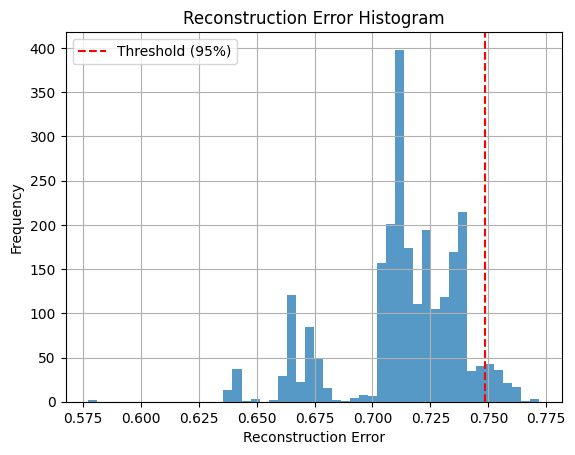

Anomaly threshold: 0.748425
Detected anomalies: 122
Accuracy = 0.735632183908046
Precision = 0.2222222222222222
Recall = 0.1111111111111111
F1 = 0.14814814814814814
[[124  14]
 [ 32   4]]
Fold 5
Epoch 1/15, Loss: 0.880316
Epoch 2/15, Loss: 0.715448
Epoch 3/15, Loss: 0.715205
Epoch 4/15, Loss: 0.715064
Epoch 5/15, Loss: 0.714815
Epoch 6/15, Loss: 0.714542
Epoch 7/15, Loss: 0.714330
Epoch 8/15, Loss: 0.714196
Epoch 9/15, Loss: 0.714128
Epoch 10/15, Loss: 0.714060
Epoch 11/15, Loss: 0.713960
Epoch 12/15, Loss: 0.713900
Epoch 13/15, Loss: 0.713880
Epoch 14/15, Loss: 0.713851
Epoch 15/15, Loss: 0.713806


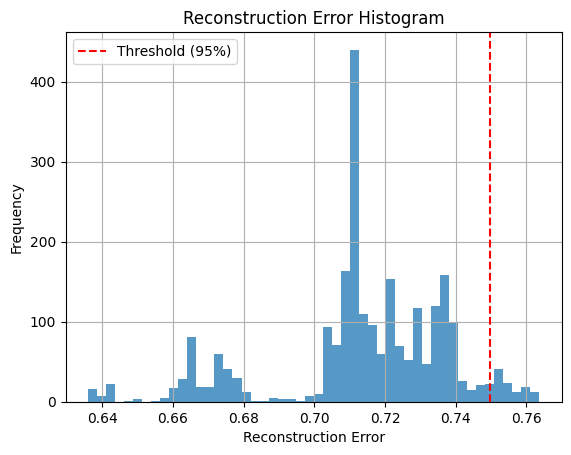

Anomaly threshold: 0.749576
Detected anomalies: 122
Accuracy = 0.7126436781609196
Precision = 0.1111111111111111
Recall = 0.05555555555555555
F1 = 0.07407407407407407
[[122  16]
 [ 34   2]]


In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = MinMaxScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)
for fold, (train_idx, val_idx) in enumerate(skf.split(features, label)):
    print(f"Fold {fold + 1}")
    train_fold_data, val_fold_data = features[train_idx], features[val_idx]
    train_fold_labels, val_fold_labels = label[train_idx], label[val_idx]

    # Train autoencoder on the training fold
    model = train_autoencoder(features[normal_indices], epochs=15, batch_size=64)

    # Evaluate on validation fold
    x_val = torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader_val = DataLoader(TensorDataset(x_val), batch_size=64)
    
    # Compute reconstruction errors
    x = model(torch.tensor(val_fold_data.reshape(-1, 4096), dtype=torch.float32).to(device)).cpu().detach().numpy()
    errors = np.mean((x - val_fold_data.reshape(-1, 4096)) ** 2, axis=1)

    # Reshape to (175, 14)
    errors = errors.reshape(val_fold_data.shape[0], val_fold_data.shape[1])

    # Aggregate per sample (e.g., mean across channels)
    sample_errors = np.mean(errors, axis=1)

    percentile = 90
    # Thresholding
    threshold = np.percentile(sample_errors, percentile)
    predictions = (sample_errors > threshold).astype(int)


    
    plot_reconstruction_error(model, val_fold_data, percentile=95)
    print_eval(predictions, val_fold_labels)

# Observation:
Comparing with and without normalizing data 

### MinMaxed scored

Accuracy = 0.7126436781609196

Precision = 0.1111111111111111

Recall = 0.05555555555555555

F1 = 0.07407407407407407

[[122  16]

[ 34   2]]

---

### StandardScaled scored


Accuracy = 0.896551724137931

Precision = 1.0

Recall = 0.5

F1 = 0.6666666666666666

[[138   0]

[ 18  18]]

---

### Without any normlaization scored (highest in cross-val):

Accuracy = 0.896551724137931

Precision = 1.0

Recall = 0.5

F1 = 0.6666666666666666

[[138   0]

[ 18  18]]